In [8]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report
#from ops import helper
plt.rcParams.update({'figure.max_open_warning': 0})
from tensorboard import program
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input,Lambda, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.losses import mse, binary_crossentropy, kl_divergence
from keras import optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split


## Functions

### create_experiment_folder

In [15]:
from keras.api._v2.keras.callbacks import experimental
def create_experiment_folder(model, experiment):
    mode = "/content/drive/MyDrive/Intrusion Detection System_Thesis/Experiments/{models}/"
    date_now = experiment +"/"
    folder_path = os.path.join(mode.format(models=model), date_now )

    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    output_file = "Configuration.csv"
    output_file = os.path.join(folder_path, output_file)

    return folder_path, output_file

### callback_configurationn

In [16]:
def callback_configurationn(folder_path,model,csv_log=False,tensorboard=False):
    log_dir = f"{folder_path}logs/fit/"               # logs
    callbacks=[]
    if csv_log:
      csv_logger = tf.keras.callbacks.CSVLogger(f"{log_dir}/csv_logger.csv", separator=',', append=False)
      callbacks.append(csv_logger)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(early_stopping)
    if tensorboard:
      tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
      callbacks.append(tensorboard_callback)
      tracking_address = f"/content/drive/MyDrive/Intrusion Detection System_Thesis/Experiments/{model}/"
      tb = program.TensorBoard()
      tb.configure(argv=[None, '--logdir', tracking_address])
      url = tb.launch()
      print(f"Tensorflow listening on {url}")

    return callbacks

### add_noise

In [17]:
def add_noise(dataset, mu=0, sigma=0.1):
    dim = list(dataset.shape)
    # creating a noise with the same dimension as the dataset
    noise = np.random.normal(mu, sigma, dim)
    signal = dataset + noise
    return signal, noise

###plot_confusion_matrix

In [18]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            pct = f"{100*count/np.sum(cm):.2f}%"
            ax.text(x=j, y=i, s=f"{count}\n{pct}", va='center', ha='center', size='xx-large')
    fig.colorbar(cax)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    ax.set_xticklabels([''] + ["normal", "attacks"])
    ax.set_yticklabels([''] + ["normal", "attacks"])
    plt.title('Confusion Matrix')
    plt.show()
    return fig


### plot_latent_space

In [32]:
def plot_latent_space(test_samples, train_samples, attack_labels_df, folder_path=None):
    # Extract the attack labels from the dataframe
    #attack_labels = attack_labels_df['Label'].values

    # Perform PCA on the encoded samples
    pca = PCA(n_components=2)
    hidden_2d = pca.fit_transform(test_samples)
    hidden_2d_train = pca.fit_transform(train_samples)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    # Plot the training data in the first subplot
    sns.scatterplot(x=hidden_2d_train[:, 0], y=hidden_2d_train[:, 1], hue=['normal']*len(hidden_2d_train),alpha=0.6,
                    ax=axs[0])
    axs[0].set_title("Training Data - Latent Space")

    # Plot the test data in the second subplot
    # Plot the test data in the second subplot with legend labels
    sns.scatterplot(x=hidden_2d[:, 0], y=hidden_2d[:, 1], hue=attack_labels_df, alpha=0.6,
                    hue_norm=(0, 1), palette={0: 'blue', 1: 'red'}, ax=axs[1])
    axs[1].set_title("Test Data - Latent Space")
    # Set the legend labels
    handles, labels = axs[1].get_legend_handles_labels()
    labels = ['Normal', 'Attacks']
    axs[1].legend(handles, labels)
    plt.show()
    # Save the figure
    if folder_path!=None:
      plt.savefig(f"{folder_path}Latent_space_2D.png")

    return fig

###plot_probability_density

In [20]:
def plot_probability_density(array, output_file, threshold):
    cutoffvalue = np.percentile(array[array["attack_label"] != "BENIGN"]["reconstruction_loss"], 95)
    # Map any reconstruction loss value above the cutoff value to the cutoff value
    array.loc[array["reconstruction_loss"] > cutoffvalue, "reconstruction_loss"] = cutoffvalue
    # Split the array into normal and attack traffic based on the attack label
    normal = array[array["attack_label"] == "BENIGN"]["reconstruction_loss"]
    attack = array[array["attack_label"] != "BENIGN"]["reconstruction_loss"]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    # Generate the kernel density estimate (KDE) plot for normal traffic using sns.distplot
    sns.distplot(normal, hist=True, kde=True, rug=False, fit=stats.norm,
                 color='darkblue',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 2, 'label': 'KDE_normal'},
                 fit_kws={'color': 'blue', 'alpha': 0.5, 'linewidth': 2, 'label': 'PDF_normal'},
                 ax=ax)
    # Generate the kernel density estimate (KDE) plot for attack traffic using sns.distplot
    sns.distplot(attack, hist=True, kde=True, rug=False, fit=stats.norm,
                 color='red',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 2, 'label': 'KDE_attack'},
                 fit_kws={'color': 'red', 'alpha': 0.5, 'linewidth': 2, 'label': 'PDF_attack'},
                 ax=ax)
    # Add a vertical line at the threshold value
    ax.axvline(x=threshold, linestyle='--', color='black', label='Threshold')
    # Add a tick at the threshold value on the x-axis
    ax.set_xticks(list(ax.get_xticks()) + [threshold])
    # Set the x-axis label
    plt.xlabel("mse")
    # Set the y-axis label
    plt.ylabel("Density")
    # Set the plot title
    plt.title(
        f"PDF and KDE of mean square error \n (cut-off at mse = {round(cutoffvalue, 2)} s.th. mse > {round(cutoffvalue, 2)} is mapped to {round(cutoffvalue, 2)})")
    # Add a legend
    plt.legend(loc='best')
    # Save the plot to a file
    plt.savefig(output_file.replace(".png", "_kde.png"))
    # Show the plot
    plt.show()
    # Generate a separate plot for the probability density function (PDF) using sns.distplot
    fig, ax = plt.subplots(figsize=(10, 6))
    # Generate the PDF plot for normal traffic using sns.distplot
    sns.distplot(normal, hist=False, kde=False, rug=False, fit=stats.norm,
                 color='darkblue',
                 hist_kws={'edgecolor': 'black'},
                 fit_kws={'color': 'blue', 'linewidth': 2, 'label': 'PDF_normal'}, ax=ax)
    # Generate the PDF plot for attack traffic using sns.distplot
    sns.distplot(attack, hist=False, kde=False, rug=False, fit=stats.norm,
                 color='red',
                 hist_kws={'edgecolor': 'black'},
                 fit_kws={'color': 'red', 'linewidth': 2, 'label': 'PDF_attack'}, ax=ax)
    # Add a vertical line at the threshold value
    ax.axvline(x=threshold, linestyle='--', color='black', label='Threshold')
    # Add a tick at the threshold value on the x-axis
    ax.set_xticks(list(ax.get_xticks()) + [threshold])
    # Set the x-axis label
    plt.xlabel("mse")
    # Set the y-axis label
    plt.ylabel("Density")
    # Set the plot title
    plt.title(
        f"PDF of mean square error \n (cut-off at mse = {round(cutoffvalue, 2)} s.th. mse > {round(cutoffvalue, 2)} is mapped to {round(cutoffvalue, 2)})")
    # Add a legend
    plt.legend(loc='best')
    # Save the plot to a file
    plt.savefig(output_file.replace(".png", "_pdf.png"))
    # Show the plot
    plt.show()

### plot_probability_density_att

In [21]:
def plot_probability_density_att(dataset, output_file, threshold):
    cutoffvalue = np.percentile(dataset[dataset["attack_label"] != "BENIGN"]["reconstruction_loss"], 95)
    # Map any reconstruction loss value above the cutoff value to the cutoff value
    dataset.loc[dataset["reconstruction_loss"] > cutoffvalue, "reconstruction_loss"] = cutoffvalue
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 10))
    # Get the unique attack labels
    attack_labels = dataset["attack_label"].unique()
    color_map = plt.get_cmap('tab20')
    cmap = [color_map(i) for i in np.linspace(0, 1, 14)]
    data_to_plot = []
    labels_to_plot = []
    for label in attack_labels:
        # Get the subset of the dataset for the current attack label
        attack_data = dataset.loc[dataset["attack_label"] == label, "reconstruction_loss"]
        if len(attack_data) > 2 and label != "BENIGN":
            data_to_plot.append(attack_data.tolist())
            labels_to_plot.append(label)
    attack_labels = labels_to_plot
    # Generate boxplots for the data
    bp = ax.boxplot(data_to_plot, labels=attack_labels[:], patch_artist=True)
    # Set the colors of the boxplots and the vertical lines
    for i, box in enumerate(bp["boxes"]):
        box.set_facecolor(cmap[i % len(cmap)])
        box.set_edgecolor('black')
    for line in bp["medians"]:
        line.set_color('black')
    for line in bp["whiskers"]:
        line.set_color('black')
    for line in bp["caps"]:
        line.set_color('black')
    # Add a horizontal line at the threshold value
    ax.axhline(y=threshold, linestyle='--', color='black', label='Threshold')
    # Add a tick at the threshold value
    ax.yaxis.set_ticks(list(ax.get_yticks()) + [threshold])
    # Set the x-axis label
    plt.xlabel("Attack Label")
    # Set the y-axis label
    plt.ylabel("mse")
    # Set the plot title
    plt.title(
        f"Boxplot of mean square error \n (cut-off at mse = {round(cutoffvalue, 2)} s.th. mse > {round(cutoffvalue, 2)} is mapped to {round(cutoffvalue, 2)})")
    # Add a legend
    plt.legend(loc='best')
    # Rotate the x-axis labels by 45 degrees for better visibility
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    # Save the plot to a file
    plt.savefig(output_file.replace(".png", "_attacks_boxplot.png"))
    # Show the plot
    plt.show()

### plot_train_reconstruction_loss

In [22]:
def plot_train_reconstruction_loss(train_reconstruction_loss, threshold):
    cutoffvalue = np.percentile(train_reconstruction_loss, 99)
    # Map any reconstruction loss value above the cutoff value to the cutoff value
    train_reconstruction_loss[train_reconstruction_loss > cutoffvalue] = cutoffvalue
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    # Generate the kernel density estimate (KDE) plot for train reconstruction loss using sns.distplot
    sns.distplot(train_reconstruction_loss, hist=True, kde=True, rug=False, fit=stats.norm,
                 color='darkblue',
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'linewidth': 2, 'label': 'KDE_train_reconstruction_loss'},
                 fit_kws={'color': 'blue', 'alpha': 0.5, 'linewidth': 2, 'label': 'PDF_train_reconstruction_loss'},
                 ax=ax)
    # Add a vertical line at the threshold value
    ax.axvline(x=threshold, linestyle='--', color='black', label='Threshold')
    # Add a tick at the threshold value on the x-axis
    ax.set_xticks(list(ax.get_xticks()) + [threshold])
    # Set the x-axis label
    plt.xlabel("mse")
    # Set the y-axis label
    plt.ylabel("Density")
    # Set the plot title
    plt.title(
        f"PDF and KDE of Train Reconstruction Loss \n (cut-off at mse = {round(cutoffvalue, 2)} s.th. mse > {round(cutoffvalue, 2)} is mapped to {round(cutoffvalue, 2)})")
    # Add a legend
    plt.legend(loc='best')
    # Save the plot to a file
    # plt.savefig(output_file.replace(".png", "_train_reconstruction_loss.png"))
    # Show the plot
    plt.show()

### plot model history

In [23]:
def plot_model_history(hist):
    fig = plt.figure()
    plt.clf()
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss', 'Validation Loss'], loc='center right')
    plt.title("Training and Validation Loss over Epochs")
    return fig

### Report Evaluation

In [42]:

def report_eval(threshold, train_recon_loss, test_recon_loss, test_ds_y, folder_path=None,output_file=None):
    if output_file !=None:
      with open(output_file, 'a', encoding="utf-8") as file:

        file.write(f'Train normal reconstruction loss: \n {stats.describe(train_recon_loss)}\n')

        print(stats.describe(test_recon_loss[label_array == 1]))
        file.write(f'Test normal reconstruction loss: \n {stats.describe(test_recon_loss[label_array == 1])}\n')

        print(stats.describe(test_recon_loss))
        file.write(f'Anomaly reconstruction loss: \n {stats.describe(test_recon_loss)}\n')

        print(
            f'1, 99% Percentile of normal reconstruction loss is {np.percentile(train_recon_loss, 1)},'
            f' {np.percentile(train_recon_loss, 99)}')
        file.write(
            f'1, 99% Percentile of normal reconstruction loss is {np.percentile(train_recon_loss, 1)},'
            f' {np.percentile(train_recon_loss, 99)}')

        print(
            f'4, 99% Percentile of abnormal reconstruction loss is {np.percentile(test_recon_loss[label_array == 1], 4)},'
            f' {np.percentile(test_recon_loss[label_array == 1], 99)}')
        file.write(
            f'4, 99% Percentile of abnormal reconstruction loss is {np.percentile(test_recon_loss[label_array == 1], 4)},'
            f' {np.percentile(test_recon_loss[label_array == 1], 99)}')


        print(f'Threshold will be {threshold}')
        file.write(f'\nThreshold will be {threshold}\n')
        # __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __
        # 1 - anomaly,
        # 0 - normal

        test_recon_loss = np.array(test_recon_loss)
        test_y_pred = np.array([1 if x > threshold else 0 for x in test_recon_loss])

        test_recon_loss_df = pd.DataFrame(test_recon_loss, columns=['reconstruction_loss'])
        test_recon_loss_df['y_pred'] = [1 if x > threshold else 0 for x in test_recon_loss]
        test_recon_loss_df['Family'] = test_ds_y['Family'].values
        test_recon_loss_df['label'] = test_ds_y['label'].values
        test_recon_loss_df['Threshold'] = len(test_ds_y['Family'].values)*[threshold]

        test_recon_loss_df.to_csv(f'{folder_path}Reconstruction_losses.csv', index=False)

        plot_probability_density(test_recon_loss_df, f'{folder_path}Reconstruction_loss.png',
                                    threshold=threshold)
        plot_probability_density_att(test_recon_loss_df, f'{folder_path}Reconstruction_loss.png',
                                            threshold=threshold)

        #       __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(test_ds_y['label'], test_y_pred)

        print('Accuracy: %f' % accuracy, '\n')
        file.write(f'Accuracy: {accuracy}\n')

        # precision : tp / (tp + fp)
        precision = precision_score(test_ds_y['label'], test_y_pred)
        print('Precision: %f' % precision, '\n')
        file.write(f'Precision: {precision}\n')

        # recall: tp / (tp + fn)
        recall = recall_score(test_ds_y['label'], test_y_pred)
        print('Recall: %f' % recall, '\n')
        file.write(f'Recall: {recall}\n')

        # F1: 2*tp / (2 tp + fp + fn)
        f1 = f1_score(test_ds_y['label'], test_y_pred)
        print('F1 score: %f' % f1, '\n')
        file.write(f'F1 score: {f1}\n')

        # kappa
        kappa = cohen_kappa_score(test_ds_y['label'], test_y_pred)
        print('Cohens kappa: %f' % kappa, '\n')
        file.write(f'Cohens kappa: {kappa}\n')

        # ROC AUC
        auc = roc_auc_score(test_ds_y['label'], test_y_pred)
        print('ROC AUC: %f' % auc, '\n')
        file.write(f'ROC AUC: {auc}\n')

        # Confusion Matrix
        cm = confusion_matrix(test_ds_y['label'], test_y_pred)
        print('Confusion Matrix:', '\n', cm, '\n')
        file.write(f'Confusion Matrix:\n {cm}\n')

        cm_fig = plot_confusion_matrix(cm)
        cm_fig.savefig(f'{folder_path}Confusion_Matrix.png')

        cls_report = classification_report(test_ds_y['label'], test_y_pred,
                                          target_names=['normal', 'attacks'])
        print(cls_report)
        wrong_pred_per_class = test_ds_y[test_ds_y["label"] != test_y_pred]["Family"].value_counts()
        correct_pred_per_class = test_ds_y[test_ds_y["label"] == test_y_pred]["Family"].value_counts()
        preds_per_class = pd.concat([wrong_pred_per_class.rename('false'),
                                    correct_pred_per_class.rename('true')], axis=1).fillna(0)
        preds_per_class["false_percent"] = round(preds_per_class["false"] /
                                                (preds_per_class["false"] + preds_per_class["true"]), 2)
        preds_per_class["support"] = preds_per_class["false"] + preds_per_class["true"]
        preds_per_class["support"] = preds_per_class["support"].astype('int')
        preds_per_class = preds_per_class.sort_values(["false_percent"], axis=0, ascending=False)
        print(preds_per_class)

        file.write(f'classification Report:\n {cls_report}\n')
        file.write(f'Wrong predictions per class:\n '
                  f'{preds_per_class}\n', )
    else:
      label_array = np.array(test_ds_y['Label'])

      print(stats.describe(train_recon_loss))
      #file.write(f'Train normal reconstruction loss: \n {stats.describe(train_recon_loss)}\n')

      print(stats.describe(test_recon_loss[label_array == 1]))
      #file.write(f'Test normal reconstruction loss: \n {stats.describe(test_recon_loss[label_array == 1])}\n')

      print(stats.describe(test_recon_loss))
      #file.write(f'Anomaly reconstruction loss: \n {stats.describe(test_recon_loss)}\n')

      print(
            f'1, 99% Percentile of normal reconstruction loss is {np.percentile(train_recon_loss, 1)},'
            f' {np.percentile(train_recon_loss, 99)}')
      #file.write(
      #      f'1, 99% Percentile of normal reconstruction loss is {np.percentile(train_recon_loss, 1)},'
      #      f' {np.percentile(train_recon_loss, 99)}')

      print(
          f'4, 99% Percentile of abnormal reconstruction loss is {np.percentile(test_recon_loss[label_array == 1], 4)},'
          f' {np.percentile(test_recon_loss[label_array == 1], 99)}')
      #file.write(
      #     f'4, 99% Percentile of abnormal reconstruction loss is {np.percentile(test_recon_loss[label_array == 1], 4)},'
      #      f' {np.percentile(test_recon_loss[label_array == 1], 99)}')


      print(f'Threshold will be {threshold}')
      #file.write(f'\nThreshold will be {threshold}\n')
        # __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __
        # 1 - anomaly,
        # 0 - normal

      test_recon_loss = np.array(test_recon_loss)
      test_y_pred = np.array([1 if x > threshold else 0 for x in test_recon_loss])

      test_recon_loss_df = pd.DataFrame(test_recon_loss, columns=['reconstruction_loss'])
      test_recon_loss_df['y_pred'] = [1 if x > threshold else 0 for x in test_recon_loss]
      test_recon_loss_df['Family'] = test_ds_y['Family'].values
      test_recon_loss_df['label'] = test_ds_y['Label'].values
      test_recon_loss_df['Threshold'] = len(test_ds_y['Family'].values)*[threshold]

      #test_recon_loss_df.to_csv(f'{folder_path}Reconstruction_losses.csv', index=False)

      #plot_probability_density(test_recon_loss_df, f'{folder_path}Reconstruction_loss.png',
      #                            threshold=threshold)
      #plot_probability_density_att(test_recon_loss_df, f'{folder_path}Reconstruction_loss.png',
      #                                    threshold=threshold)

      #       __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __
      # accuracy: (tp + tn) / (p + n)
      accuracy = accuracy_score(test_ds_y['Label'], test_y_pred)

      print('Accuracy: %f' % accuracy, '\n')
      #file.write(f'Accuracy: {accuracy}\n')

      # precision : tp / (tp + fp)
      precision = precision_score(test_ds_y['Label'], test_y_pred)
      print('Precision: %f' % precision, '\n')
      #file.write(f'Precision: {precision}\n')

      # recall: tp / (tp + fn)
      recall = recall_score(test_ds_y['Label'], test_y_pred)
      print('Recall: %f' % recall, '\n')
      #file.write(f'Recall: {recall}\n')

      # F1: 2*tp / (2 tp + fp + fn)
      f1 = f1_score(test_ds_y['Label'], test_y_pred)
      print('F1 score: %f' % f1, '\n')
      #file.write(f'F1 score: {f1}\n')

      # kappa
      kappa = cohen_kappa_score(test_ds_y['Label'], test_y_pred)
      print('Cohens kappa: %f' % kappa, '\n')
      #file.write(f'Cohens kappa: {kappa}\n')

      # ROC AUC
      auc = roc_auc_score(test_ds_y['Label'], test_y_pred)
      print('ROC AUC: %f' % auc, '\n')
      #file.write(f'ROC AUC: {auc}\n')

      # Confusion Matrix
      cm = confusion_matrix(test_ds_y['Label'], test_y_pred)
      print('Confusion Matrix:', '\n', cm, '\n')
      #file.write(f'Confusion Matrix:\n {cm}\n')

      cm_fig = plot_confusion_matrix(cm)
      #cm_fig.savefig(f'{folder_path}Confusion_Matrix.png')

      cls_report = classification_report(test_ds_y['Label'], test_y_pred,
                                        target_names=['normal', 'attacks'])
      print(cls_report)
      wrong_pred_per_class = test_ds_y[test_ds_y["Label"] != test_y_pred]["Family"].value_counts()
      correct_pred_per_class = test_ds_y[test_ds_y["Label"] == test_y_pred]["Family"].value_counts()
      preds_per_class = pd.concat([wrong_pred_per_class.rename('false'),
                                  correct_pred_per_class.rename('true')], axis=1).fillna(0)
      preds_per_class["false_percent"] = round(preds_per_class["false"] /
                                              (preds_per_class["false"] + preds_per_class["true"]), 2)
      preds_per_class["support"] = preds_per_class["false"] + preds_per_class["true"]
      preds_per_class["support"] = preds_per_class["support"].astype('int')
      preds_per_class = preds_per_class.sort_values(["false_percent"], axis=0, ascending=False)
      print(preds_per_class)

      #file.write(f'classification Report:\n {cls_report}\n')
      #file.write(f'Wrong predictions per class:\n '
      #          f'{preds_per_class}\n', )


    return cls_report

## **Models**

### AutoEncoder

In [25]:
class Encoder:
    def __init__(self, hidden_layer_sizes, latent_dim, batch_norm, dropout, dropout_rate):
        self.input_shape = 50
        self.hidden_layer_sizes = hidden_layer_sizes
        self.latent_dim = latent_dim
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.dropout_rate = dropout_rate

    def build(self):
        inputs = Input(shape=self.input_shape, name='encoder_input')
        x = inputs
        layer_sizes =  self.hidden_layer_sizes + [self.latent_dim]
        for i, size in enumerate(layer_sizes[:-2]):
            x = Dense(layer_sizes[i+1], name=f"Encoder-Layer{i+1}")(x)
            if self.batch_norm:
                x = BatchNormalization(name=f'encoder-Layer-Normalization{i+1}')(x)
            x = LeakyReLU(name=f'Encoder-Layer-Activation{i+1}')(x)
            if self.dropout and K.learning_phase():
                x = Dropout(rate=self.dropout_rate, name=f"Encoder-Layer{i+1}-Dropout")(x)

        latent_space = Dense( self.latent_dim, name=f"Latent_space-Layer")(x)

        print(f"\nEncoder arch: D{'-D'.join(map(str, layer_sizes[1:-1]))}-D{layer_sizes[-1]}\n")

        encoder = keras.Model(inputs, latent_space, name="encoder")
        encoder.summary()
        return encoder


class Decoder:
    def __init__(self, hidden_layer_sizes, latent_dim, batch_norm, dropout, dropout_rate):
        self.input_shape = 50
        self.hidden_layer_sizes = hidden_layer_sizes
        self.latent_dim = latent_dim
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.dropout_rate = dropout_rate

    def build(self):
        latent_inputs = Input(shape=(self.latent_dim,), name='Decoder-input')
        x = latent_inputs
        layer_sizes = [self.latent_dim] + self.hidden_layer_sizes[::-1]
        for i, size in enumerate(layer_sizes[:-2]):
            x = Dense(layer_sizes[i+1], name=f"Decoder-Layer{i+1}")(x)
            if self.batch_norm:
                x = BatchNormalization(name=f'Decoder-Layer-Normalization{i+1}')(x)
            x = LeakyReLU(name=f'Decoder-Layer-Activation{i+1}')(x)
            if self.dropout and K.learning_phase():
                x = Dropout(rate=self.dropout_rate, name=f"Encoder-Layer{i+1}-Dropout")(x)

        outputs = Dense(self.input_shape, name=f"Output-Layer")(x)

        print(f"\nDecoder arch: D{'-D'.join(map(str, layer_sizes[0:-1]))}-D{layer_sizes[-1]}\n")

        # Instantiate the decoder model:
        decoder = Model(latent_inputs, outputs, name='decoder')
        decoder.summary()
        return decoder


class Autoencoder(keras.Model):
    def __init__(self, hidden_layer_sizes, latent_dim, batch_norm=True, dropout=True, dropout_rate=0.2, **kwargs):
        super().__init__(**kwargs)

        self.encoder = Encoder(hidden_layer_sizes, latent_dim, batch_norm=batch_norm, dropout=dropout, dropout_rate=dropout_rate ).build()
        #self.encoder = Encoder(hidden_layer_sizes, latent_dim, batch_norm=batch_norm, dropout=dropout, dropout_rate=dropout_rate ).build()

        #self.decoder = Decoder(hidden_layer_sizes, latent_dim, batch_norm=batch_norm, dropout=dropout, dropout_rate=dropout_rate).build()
        self.decoder = Decoder(hidden_layer_sizes, latent_dim, batch_norm=batch_norm, dropout=dropout, dropout_rate=dropout_rate).build()

        self.lr = 0.001
        self.recon_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.optimizers.RMSprop(learning_rate=self.lr)
        self.params = {"lr": self.lr,
                       "epochs": 100,
                       "batch_size": 1024}

    def call(self, inputs):
        x = self.encoder(inputs)
        #rec1 = self.decoder1(x)
        #x = self.encoder2(rec1)
        reconstructed = self.decoder(x)
        return reconstructed


# Load DATA

In [10]:
ds = pd.read_csv("/content/drive/MyDrive/Netmode/fedxai4dga/labeled_dataset_features_scaled.csv")
#Specify the path to read

train_ds = ds[ds['Label']==0]
test_ds_dga = ds[ds['Label']==1]
train_ds_x = train_ds.iloc[:,:-3]
train_ds_y = train_ds.iloc[:,-3:]

train_x, test_x_norm, train_y, test_y_norm = train_test_split(train_ds_x, train_ds_y, test_size=0.20, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)


# Check the shapes of the resulting DataFrames
print("Train Features Shape:", train_x.shape)
print("Validation Features Shape:", valid_x.shape)
print("Test Features Shape:", test_x_norm.shape)
print("Train Labels Shape:", train_y.shape)
print("Validation Labels Shape:", valid_y.shape)
print("Test Labels Shape:", test_y_norm.shape)
print("Test Labels Shape:", test_ds_dga.shape)


Train Features Shape: (540000, 50)
Validation Features Shape: (180000, 50)
Test Features Shape: (180000, 50)
Train Labels Shape: (540000, 3)
Validation Labels Shape: (180000, 3)
Test Labels Shape: (180000, 3)
Test Labels Shape: (570000, 53)


In [14]:
test_norm = pd.concat([test_x_norm , test_y_norm], axis=1)
test_df_merged = pd.concat([test_norm, test_ds_dga.sample(n=len(test_x_norm),random_state=42)], ignore_index=True)
test_df_merged

,Length,Max_DeciDig_Seq,Max_Let_Seq,Freq_A,Freq_B,Freq_C,Freq_D,Freq_E,Freq_F,Freq_G,...,Vowel_Freq,Vowel_Ratio,Max_Gap,Reputation,Words_Freq,Words_Mean,Entropy,Name,Label,Family
0,-0.315723,-0.516433,0.103599,1.234882,-0.638741,1.197386,-0.708656,0.554760,-0.571107,-0.580025,...,-0.151804,0.124928,-0.046436,0.486853,0.338942,0.403181,-0.819384,carshares.jp,0,tranco
1,-0.800438,-0.516433,-0.353829,-1.026854,-0.638741,1.197386,-0.708656,0.554760,-0.571107,-0.580025,...,-0.151804,0.773396,-0.046436,0.137211,0.338942,-0.110156,-0.789749,citynet.uz,0,tranco
2,0.662192,-0.516433,1.197035,1.234882,-0.638741,-0.759964,-0.708656,0.554760,-0.571107,-0.580025,...,1.110954,0.576808,-0.046436,1.565692,0.338942,0.909108,0.634035,hospitalmanises.es,0,tranco
3,-0.112761,2.000976,-0.353829,-1.026854,1.516084,-0.759964,-0.708656,1.213176,-0.571107,1.708948,...,-0.151804,-0.097364,-0.046436,0.356124,0.338942,-0.370138,-0.110751,betogel110.com,0,tranco
4,0.237218,-0.516433,0.690948,0.571513,-0.638741,-0.759964,1.600808,1.213176,-0.571107,-0.580025,...,1.110954,1.272379,-0.046436,0.774032,1.146985,0.147534,-0.117200,postodesaude.org,0,tranco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,1.461023,2.000976,1.920125,1.234882,-0.638741,-0.759964,1.328986,0.554760,1.719621,-0.580025,...,2.117803,0.517322,-0.046436,0.925298,1.858306,-0.370138,2.037324,uvipidahafilqjoretij501.cc,1,corebot
359996,2.168970,2.018303,-1.204381,0.571513,1.747239,1.197386,1.710455,1.213176,1.841319,-0.580025,...,-0.151804,-1.450097,-0.046436,0.056775,2.500972,0.044716,1.470884,ddb918132e7ad5efb53b01d54cfbb3681f.cn,1,dyre
359997,1.292980,-0.516433,2.051121,-1.026854,1.691932,-0.759964,-0.708656,1.213176,-0.571107,1.708948,...,2.117803,0.773396,-0.046436,1.727136,1.146985,0.992801,1.053011,usjbiologistbikerepil.com,1,banjori
359998,2.060741,2.018303,-1.978454,1.234882,1.691932,1.666295,1.328986,0.554760,1.719621,-0.580025,...,-0.151804,-1.416223,-0.046436,0.056775,1.146985,0.656983,1.454365,20e3a624b9c848839a0cf05d457883bc.win,1,wd


#Training Model

In [26]:
hidden_layer_sizes = [40,23,15]
latent_space = 8
#arch_str = '_'.join(map(str, hidden_layer_sizes + [latent_space] + hidden_layer_sizes[::-1]))
#folder_path, output_file = create_experiment_folder("AutoEncoders" , arch_str)
#callbacks = callback_configurationn(folder_path,"AutoEncoders")

In [27]:
model = Autoencoder(hidden_layer_sizes=hidden_layer_sizes,
                    latent_dim=latent_space,
                    batch_norm=False,
                    dropout=False,
                    dropout_rate=0.2)
model.compile(loss=model.recon_loss, optimizer=model.optimizer)

hist = model.fit(train_ds_x,train_ds_x, epochs=100,
                               validation_data=(valid_x,valid_x),
                               #callbacks=callbacks,
                               batch_size=1024,
                               verbose=1)


Encoder arch: D23-D15-D8

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 50)]              0         
                                                                 
 Encoder-Layer1 (Dense)      (None, 23)                1173      
                                                                 
 Encoder-Layer-Activation1   (None, 23)                0         
 (LeakyReLU)                                                     
                                                                 
 Encoder-Layer2 (Dense)      (None, 15)                360       
                                                                 
 Encoder-Layer-Activation2   (None, 15)                0         
 (LeakyReLU)                                                     
                                                                 
 Latent_space-Layer (Dense)  (No

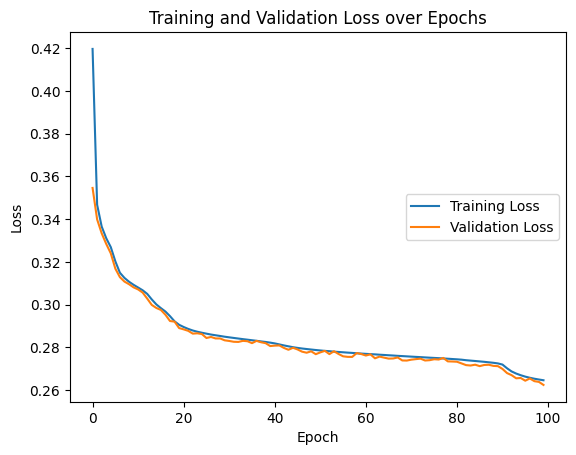

In [28]:
lr = plot_model_history(hist)
#lr.savefig(f'{folder_path}Learning_curves.png')

352/352 [==============================] - 1s 2ms/step


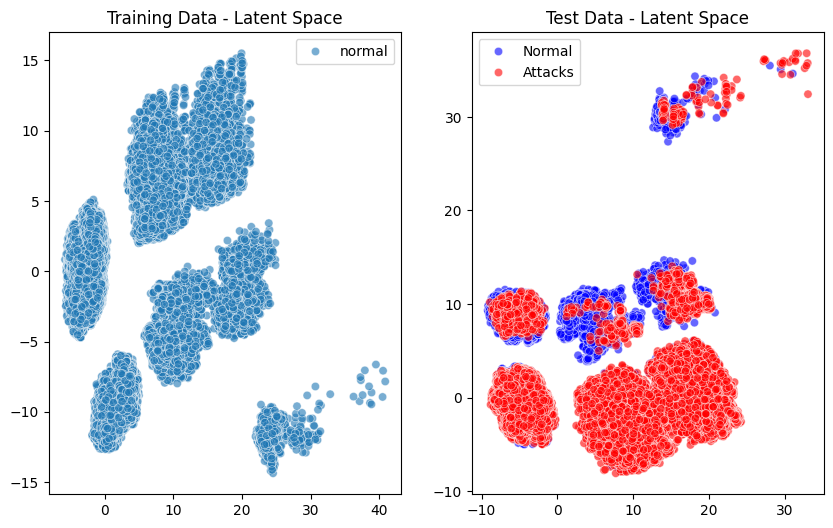

In [33]:
code_train = model.encoder.predict(train_ds_x,batch_size=1024)
code_test = model.encoder.predict(test_df_merged.iloc[:,:-3],batch_size=1024)

_ = plot_latent_space(code_test, code_train, test_df_merged.iloc[:,-2], folder_path=None)

In [34]:
loss_fun = model.recon_loss
# predictions of Normal in Train set
x_pred = model.predict(train_ds_x,batch_size=1024)
train_recon_loss = loss_fun(train_ds_x,x_pred)
# Threshold Decision
threshold = np.percentile(train_recon_loss, 95)

879/879 [==============================] - 5s 5ms/step


<ipython-input-22-14416d419cf7>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_reconstruction_loss, hist=True, kde=True, rug=False, fit=stats.norm,


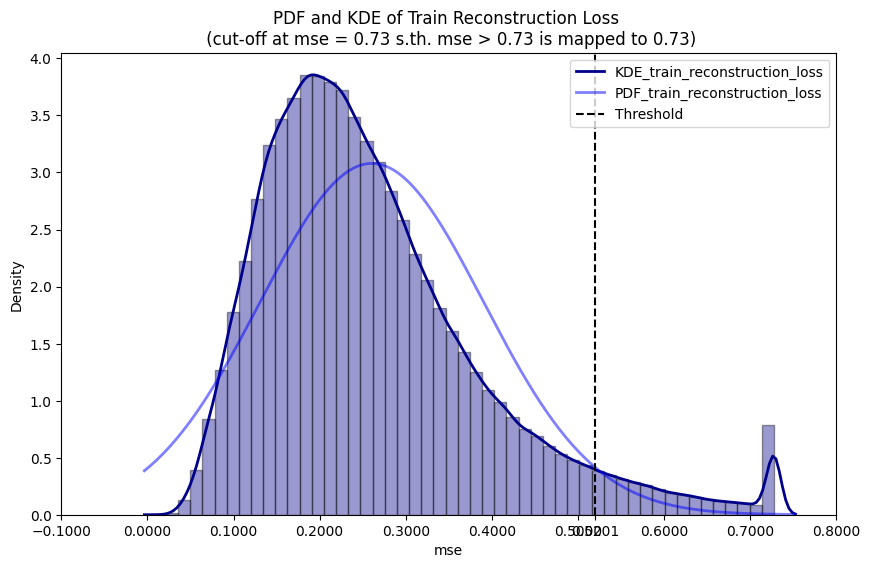

In [35]:
plot_train_reconstruction_loss(np.array(train_recon_loss),threshold)

In [37]:
# predictions in Test set
test_pred = model.predict(test_df_merged.iloc[:,:-3],batch_size=1024)
test_recon_loss = loss_fun(test_df_merged.iloc[:,:-3], test_pred)

352/352 [==============================] - 2s 6ms/step


DescribeResult(nobs=900000, minmax=(0.02147746, 3.5771692), mean=0.26246983, variance=0.019333100938506285, skewness=2.0510647916272915, kurtosis=10.33800263712484)
DescribeResult(nobs=180000, minmax=(0.03664139, 4.5680985), mean=0.715529, variance=0.21854839445273752, skewness=1.2323813949788374, kurtosis=1.3372237165034075)
DescribeResult(nobs=360000, minmax=(0.02736174, 4.5680985), mean=0.48886254, variance=0.1702700218652578, skewness=1.8998250980843532, kurtosis=3.8985632773687264)
1, 99% Percentile of normal reconstruction loss is 0.06788496859371662, 0.7276250702142717
4, 99% Percentile of abnormal reconstruction loss is 0.18851078629493714, 2.151968965530397
Threshold will be 0.5201343536376946
Accuracy: 0.750214 

Precision: 0.917251 

Recall: 0.550050 

F1 score: 0.687703 

Cohens kappa: 0.500428 

ROC AUC: 0.750214 

Confusion Matrix: 
 [[171068   8932]
 [ 80991  99009]] 



<ipython-input-18-4e316da62ce0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ["normal", "attacks"])
<ipython-input-18-4e316da62ce0>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ["normal", "attacks"])


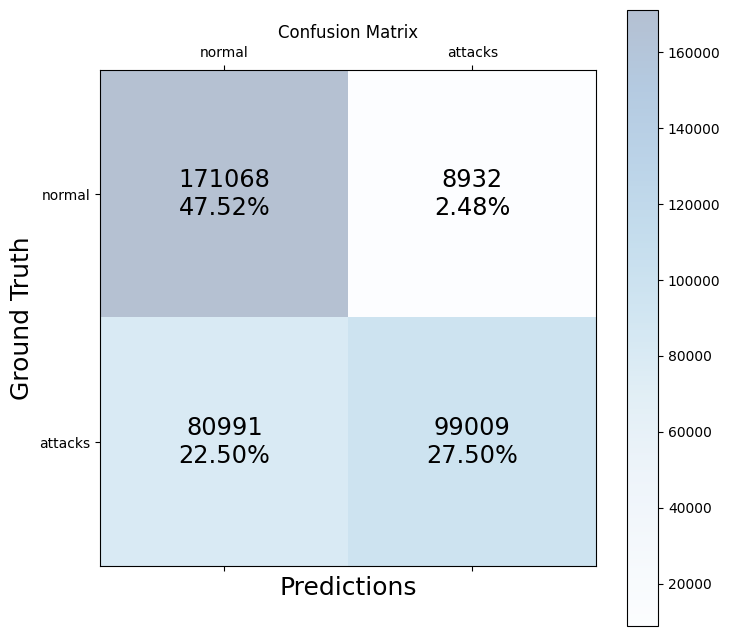

              precision    recall  f1-score   support

      normal       0.68      0.95      0.79    180000
     attacks       0.92      0.55      0.69    180000

    accuracy                           0.75    360000
   macro avg       0.80      0.75      0.74    360000
weighted avg       0.80      0.75      0.74    360000

                false    true  false_percent  support
Family                                               
nymaim2        4704.0      28           0.99     4732
suppobox       4664.0      89           0.98     4753
gozi           4600.0      97           0.98     4697
virut          4649.0     132           0.97     4781
padcrypt       4588.0     148           0.97     4736
qsnatch        4317.0     492           0.90     4809
symmi          3986.0     718           0.85     4704
conficker      3817.0     855           0.82     4672
proslikefan    3885.0     839           0.82     4724
torpig         3651.0     995           0.79     4646
pushdo         3702.0    

In [43]:
clr = report_eval(threshold, train_recon_loss, test_recon_loss, test_df_merged.iloc[:,-2:], folder_path=None,output_file=None)